<a href="https://colab.research.google.com/github/ImIm20/portfolio/blob/main/Summer_Program_Final_Project_Imroatus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summer Program Final Project: Taxi Passenger Hotspots Prediction
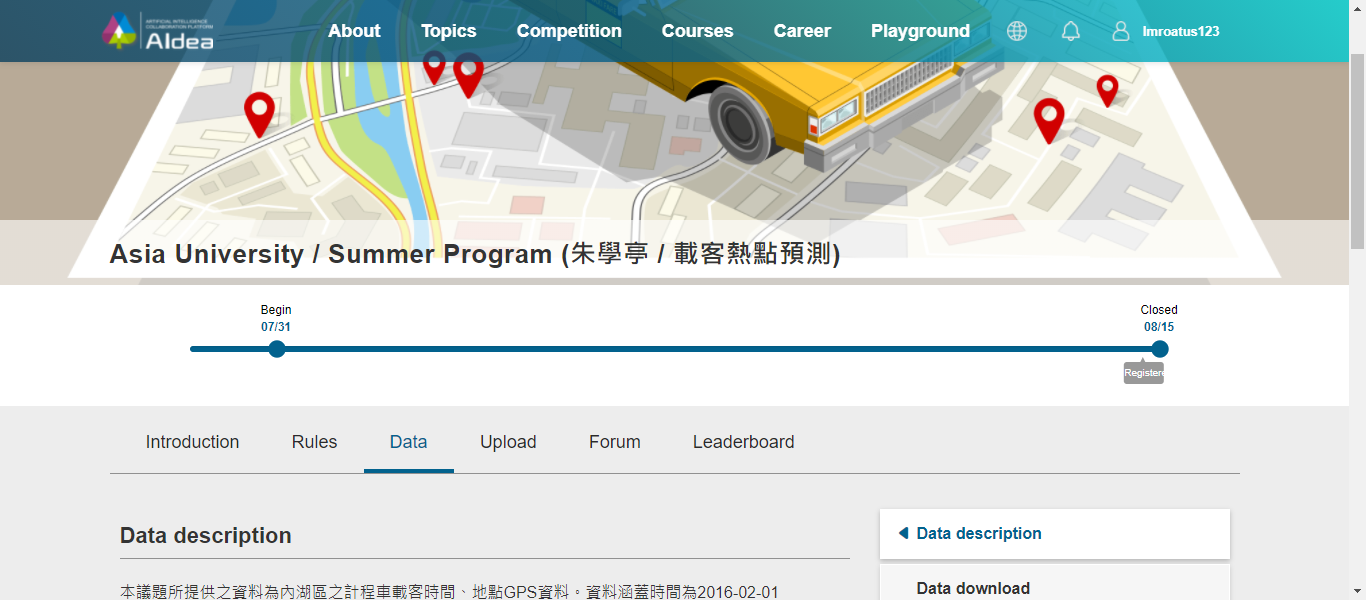
We often see empty taxis on the road looking for passengers, and this is certainly a problem.
**Problem for whom?**


1.   Taxi Company : Taxi companies will pay more for higher taxi operating hours so that the company's profits are not maximized. 

2.   Taxi Drivers and Customers : Taxi drivers waste their time and energy looking for passengers, so do the customers.

3. Environment : When taxis go around looking for passengers, it can cause traffic jam and pollution.

**How to solve it?**
In this project, the location and time will be predicted based on passenger demand from historical data, so that the amount of empty taxis and their exhaust emissions can decrease and thus the quality of transportation services can be improved 




The rank of the result in leaderboard is 5th from 323rd participants from some countries like south korea, japan, indonesia, india, etc. with RMSE = 8.4209968
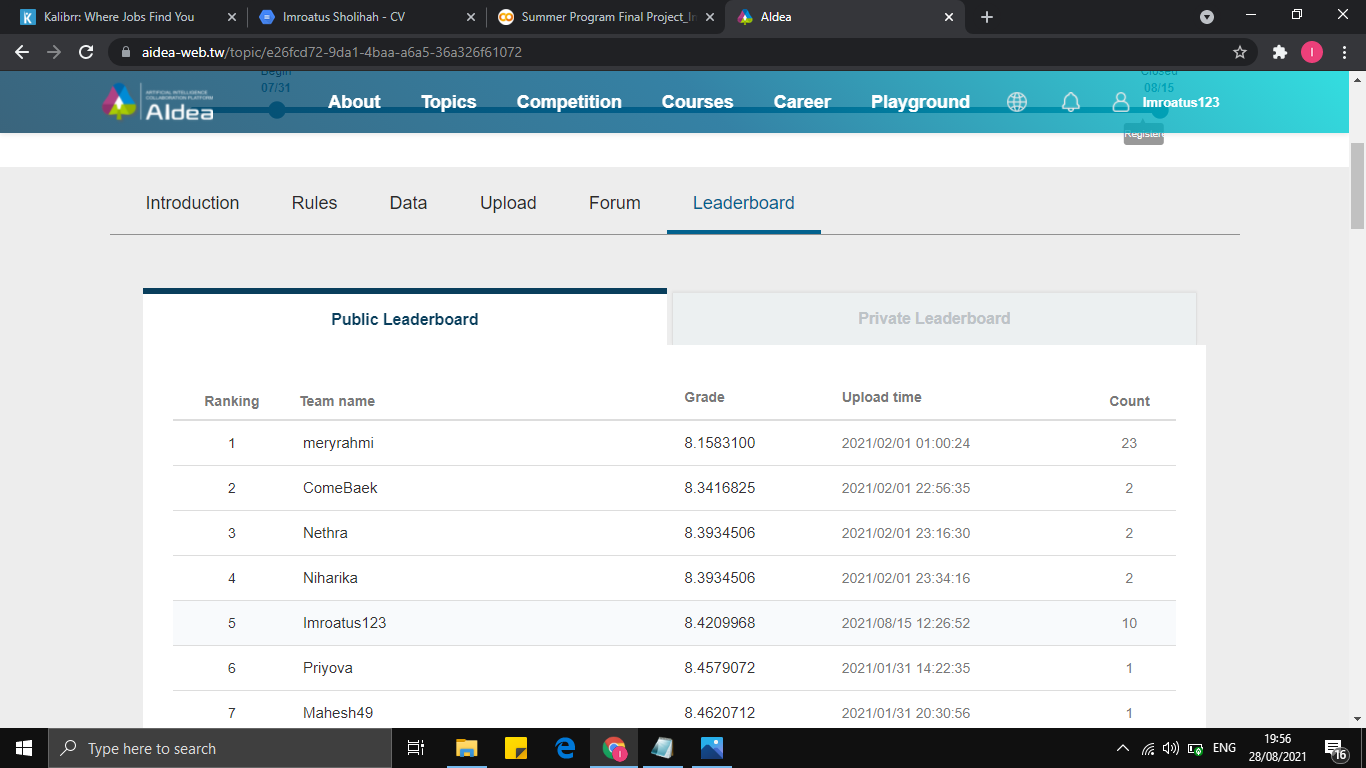

# Data Preprocessing

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Download the dataset and unzip it.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(
    file_id='13BhHdMYUP7VxYV1PNoQGx-wldEMebjyd',
    dest_path='./content', unzip=True)

Unzipping...Done.


In [ ]:
#Read training data
df_train = pd.read_csv('taxi_data/train_hire_stats.csv')
df_train.shape

(219600, 4)

## Data exlanation


1.   Zone_ID : location ID where driver meets customer.
2.   Date : date, format YYYY-mm-dd, such as 2017-02-01.
3.   Hour_slot : time period when driver meets customer, calculated in one hour, the value of this field is 0-23. 0 means between 0:00:00-0:59:59 time period, 1 means 1:00:00~1:59:59, and so on.
4.    Hire_count : number of demand.

**This project will predict Hire_count variable. And the features from this data are all variables except Hire_count**



In [ ]:
df_train.head()

,Zone_ID,Date,Hour_slot,Hire_count
0,1,2016-02-01,0,0
1,1,2016-02-01,1,0
2,1,2016-02-01,2,0
3,1,2016-02-01,3,0
4,1,2016-02-01,4,0


In [ ]:
df_train.info() # as we can see below there is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219600 entries, 0 to 219599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Zone_ID     219600 non-null  int64 
 1   Date        219600 non-null  object
 2   Hour_slot   219600 non-null  int64 
 3   Hire_count  219600 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.7+ MB


## data preprocessing
Based on what I explained before, date is one of the features that can affect the number of demands. And based on the analysis, the Date has very dynamic pattern because it is influenced by weekdays and holidays which sometimes change unexpectedly (weekdays become workdays, workdays become hoidays). So, if we use Date as a feature directly, the model will catch the pattern from Date badly. Thus, we're gonna make variable isworkday and workdays.

In [ ]:
#holidays -> holiday in weekday 
#makeupworkdays -> workday in holiday
holidays=set(['2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12',
              '2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', 
              '2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27', 
              '2017-01-30', '2017-02-01','2017-02-27', '2017-02-28'])
makeupworkdays = set(['2016-06-04', '2016-09-10', '2017-02-18'])

In [ ]:
#Declare array 1D (isworkday & weekday) contains number 1 as much as df_train rows.
isworkday = np.ones((len(df_train),), dtype=int)
weekday = np.ones((len(df_train),), dtype=int)
print(isworkday)
print(weekday)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [ ]:
'''Compute weekday & workday. weekday() is a function 
that return 0 == Monday, 1 == Tuesday, 2 == Wednesday, 
3 == Thursday, 4 == Friday,  5 == Saturday, 6 == Sunday'''
from datetime import datetime

for index, row in df_train.iterrows(): # looping every row
    if row['Date'] in holidays:
        isworkday[index] = 0 #not workday if row['date'] in holiday
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday[index]= dd.weekday() #change the value of weekday
        if weekday[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday[index] = 0 #not workday if sun/sat and not in makeupworkdays


In [ ]:
print(isworkday[2111:2140])
print(weekday[2111:2140])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
[3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5]


In [ ]:
RawX = pd.DataFrame(df_train[["Zone_ID", "Hour_slot"]])
RawX['isworkday'] = isworkday
RawX['weekday'] = weekday
RawX.head()

,Zone_ID,Hour_slot,isworkday,weekday
0,1,0,1,0
1,1,1,1,0
2,1,2,1,0
3,1,3,1,0
4,1,4,1,0


In [ ]:
#Use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
#Build encoder
enc.fit_transform(RawX)
enc.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5, 6])]

In [ ]:
#Transform data into one hot vector
X = enc.transform(RawX).toarray()
X.shape

(219600, 58)

In [ ]:
X[0:3, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
#Resize y into (0,1) divide with 339 since the max value in df_train['hire_count'] is 339
y = df_train["Hire_count"].values/339.0
y.shape

(219600,)

# Data Modelling

## Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout

In [ ]:
# create and fit a Baseline Neural Network Model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=58))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [ ]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=1024, verbose=1)

Epoch 1/10
215/215 [==============================] - 1s 3ms/step - loss: 6.8373e-04
Epoch 2/10
215/215 [==============================] - 1s 3ms/step - loss: 6.8221e-04
Epoch 3/10
215/215 [==============================] - 1s 3ms/step - loss: 6.8064e-04
Epoch 4/10
215/215 [==============================] - 1s 3ms/step - loss: 6.8260e-04
Epoch 5/10
215/215 [==============================] - 1s 3ms/step - loss: 6.7673e-04
Epoch 6/10
215/215 [==============================] - 1s 3ms/step - loss: 6.8394e-04
Epoch 7/10
215/215 [==============================] - 1s 3ms/step - loss: 6.7965e-04
Epoch 8/10
215/215 [==============================] - 1s 3ms/step - loss: 6.7806e-04
Epoch 9/10
215/215 [==============================] - 1s 3ms/step - loss: 6.7410e-04
Epoch 10/10
215/215 [==============================] - 1s 3ms/step - loss: 6.7469e-04


In [ ]:
df_test = pd.read_csv('taxi_data/test_hire_stats.csv')
df_test.shape

(6048, 5)

In [ ]:
#Declare weekday & workday
isworkday2 = np.ones((len(df_test),), dtype=int)
weekday2 = np.ones((len(df_test),), dtype=int)

In [ ]:
for index, row in df_test.iterrows():
    if row['Date'] in holidays:
        isworkday2[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday2[index]= dd.weekday() 
        if weekday2[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday2[index] = 0

In [ ]:
Test = pd.DataFrame(df_test[["Zone_ID", "Hour_slot"]])
Test['isworkday'] = isworkday2
Test['weekday'] = weekday2

In [ ]:
Xtest = enc.transform(Test).toarray()
Xtest.shape

(6048, 58)

In [ ]:
yt = model.predict(Xtest)*339.0

In [ ]:
yt

array([[ 1.0840266 ],
       [ 0.4084461 ],
       [ 0.77611655],
       ...,
       [18.699259  ],
       [17.394014  ],
       [15.164517  ]], dtype=float32)

In [ ]:
yt = yt.round(0)
yt

array([[ 2.],
       [ 1.],
       [ 2.],
       ...,
       [20.],
       [20.],
       [16.]], dtype=float32)

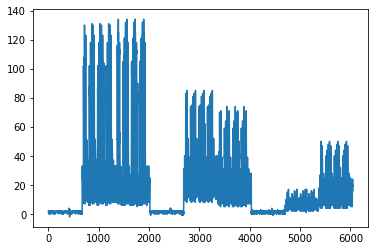

In [ ]:
plt.plot(yt)

In [ ]:
dfOut = pd.DataFrame(df_test[["Test_ID", "Date", "Hour_slot"]])
dfOut['Hire_count'] = yt

In [ ]:
dfOut

,Test_ID,Date,Hour_slot,Hire_count
0,0,2017-02-01,0,2.0
1,1,2017-02-01,1,1.0
2,2,2017-02-01,2,2.0
3,3,2017-02-01,3,1.0
4,4,2017-02-01,4,2.0
...,...,...,...,...
6043,6043,2017-02-28,19,24.0
6044,6044,2017-02-28,20,19.0
6045,6045,2017-02-28,21,20.0
6046,6046,2017-02-28,22,20.0


In [ ]:
dfOut.to_csv('Result21 (3).csv', index= False)

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('Result21 (3).csv')

In [ ]:
data.head(13)

,Test_ID,Date,Hour_slot,Hire_count
0,0,2017-02-01,0,3.0
1,1,2017-02-01,1,-0.0
2,2,2017-02-01,2,2.0
3,3,2017-02-01,3,1.0
4,4,2017-02-01,4,3.0
5,5,2017-02-01,5,2.0
6,6,2017-02-01,6,2.0
7,7,2017-02-01,7,2.0
8,8,2017-02-01,8,1.0
9,9,2017-02-01,9,1.0


In [ ]:
#change negative value, because impossible if the Hire_count value is negative
data.Hire_count[data.Hire_count < 0] = 0
data 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Test_ID,Date,Hour_slot,Hire_count
0,0,2017-02-01,0,3.0
1,1,2017-02-01,1,-0.0
2,2,2017-02-01,2,2.0
3,3,2017-02-01,3,1.0
4,4,2017-02-01,4,3.0
...,...,...,...,...
6043,6043,2017-02-28,19,21.0
6044,6044,2017-02-28,20,15.0
6045,6045,2017-02-28,21,17.0
6046,6046,2017-02-28,22,18.0


In [ ]:
data.head(13)

,Test_ID,Date,Hour_slot,Hire_count
0,0,2017-02-01,0,3.0
1,1,2017-02-01,1,-0.0
2,2,2017-02-01,2,2.0
3,3,2017-02-01,3,1.0
4,4,2017-02-01,4,3.0
5,5,2017-02-01,5,2.0
6,6,2017-02-01,6,2.0
7,7,2017-02-01,7,2.0
8,8,2017-02-01,8,1.0
9,9,2017-02-01,9,1.0


In [ ]:
data.to_csv('Result1000.csv', index= False)